In [1]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from tqdm import tqdm
              
import warnings
warnings.filterwarnings("ignore")

In [2]:
dc_tm = lambda splitratio: [[np.sqrt(1-splitratio), 1j*np.sqrt(splitratio)], [1j*np.sqrt(splitratio), np.sqrt(1-splitratio)]]
ps_tm = lambda phase: [[np.exp(-1j*phase/2), 0], [0, np.exp(1j*phase/2)]]
psr_tm = lambda delay, wavelength: [[np.exp(1j*2*np.pi/wavelength * delay * const.c), 0], [0, 1]]

In [3]:
dvd_delay = 0.5e-12

no_wavelength = 401
no_theta = 21
no_splitratio = 41
no_pol_frac = 21

In [4]:
wavelength = np.linspace(1.31, 1.33, num=no_wavelength) * 1e-6
theta = np.linspace(0, np.pi, num=no_theta)
splitratio = np.linspace(0, 1, num=no_splitratio)
pol_frac = np.linspace(0, 1, num=no_pol_frac)

pol_frac_sweep = np.zeros((1, 1, 1, 1, len(pol_frac), 2, 1), dtype=complex)
for idd_pol, pol_val in tqdm(enumerate(pol_frac), total=len(pol_frac), desc='Polarization Fraction Sweep'):
              pol_frac_sweep[0, 0, 0, 0, idd_pol, :, :] = np.array([[pol_val],[1-pol_val]])/np.sqrt(pol_val**2 + (1-pol_val)**2)

dc1_sr_sweep = np.zeros((1, 1, len(splitratio), 1, 1, 2, 2), dtype=complex)
for idd_sr, sr_val in tqdm(enumerate(splitratio), total=len(splitratio), desc='Split Ratio Sweep for DC1'):
              dc1_sr_sweep[0, 0, idd_sr, 0, 0, :, :] = dc_tm(sr_val)
              
dc2_sr_sweep = np.zeros((1, 1, 1, len(splitratio), 1, 2, 2), dtype=complex)
for idd_sr, sr_val in tqdm(enumerate(splitratio), total=len(splitratio), desc='Split Ratio Sweep for DC2'):
              dc2_sr_sweep[0, 0, 0, idd_sr, 0, :, :] = dc_tm(sr_val)
              
ps_theta_sweep = np.zeros((1, len(theta),1, 1, 1, 2, 2), dtype=complex)
for idd_theta, theta_val in tqdm(enumerate(theta), total=len(theta), desc='Theta Sweep'):
              ps_theta_sweep[0, idd_theta, 0, 0, 0, :, :] = ps_tm(theta_val)
              
psr_wave_sweep = np.zeros(( len(wavelength), 1, 1, 1, 1, 2, 2), dtype=complex)
for idd_wave, wave_val in tqdm(enumerate(wavelength), total=len(wavelength), desc='Wavelength Sweep'):
              psr_wave_sweep[idd_wave, 0, 0, 0, 0, :, :] = psr_tm(dvd_delay, wave_val)

Wavelength Sweep: 100%|██████████| 401/401 [00:00<00:00, 778664.77it/s]


In [5]:
single_stage_tunable_psrc = dc2_sr_sweep @ ps_theta_sweep @ dc1_sr_sweep @ psr_wave_sweep @ pol_frac_sweep

In [6]:
max_loss_single_stage_tunable_psrc = np.min(10*np.log10(np.abs(single_stage_tunable_psrc)**2), axis=0)
min_loss_single_stage_tunable_psrc = np.max(10*np.log10(np.abs(single_stage_tunable_psrc)**2), axis=0)

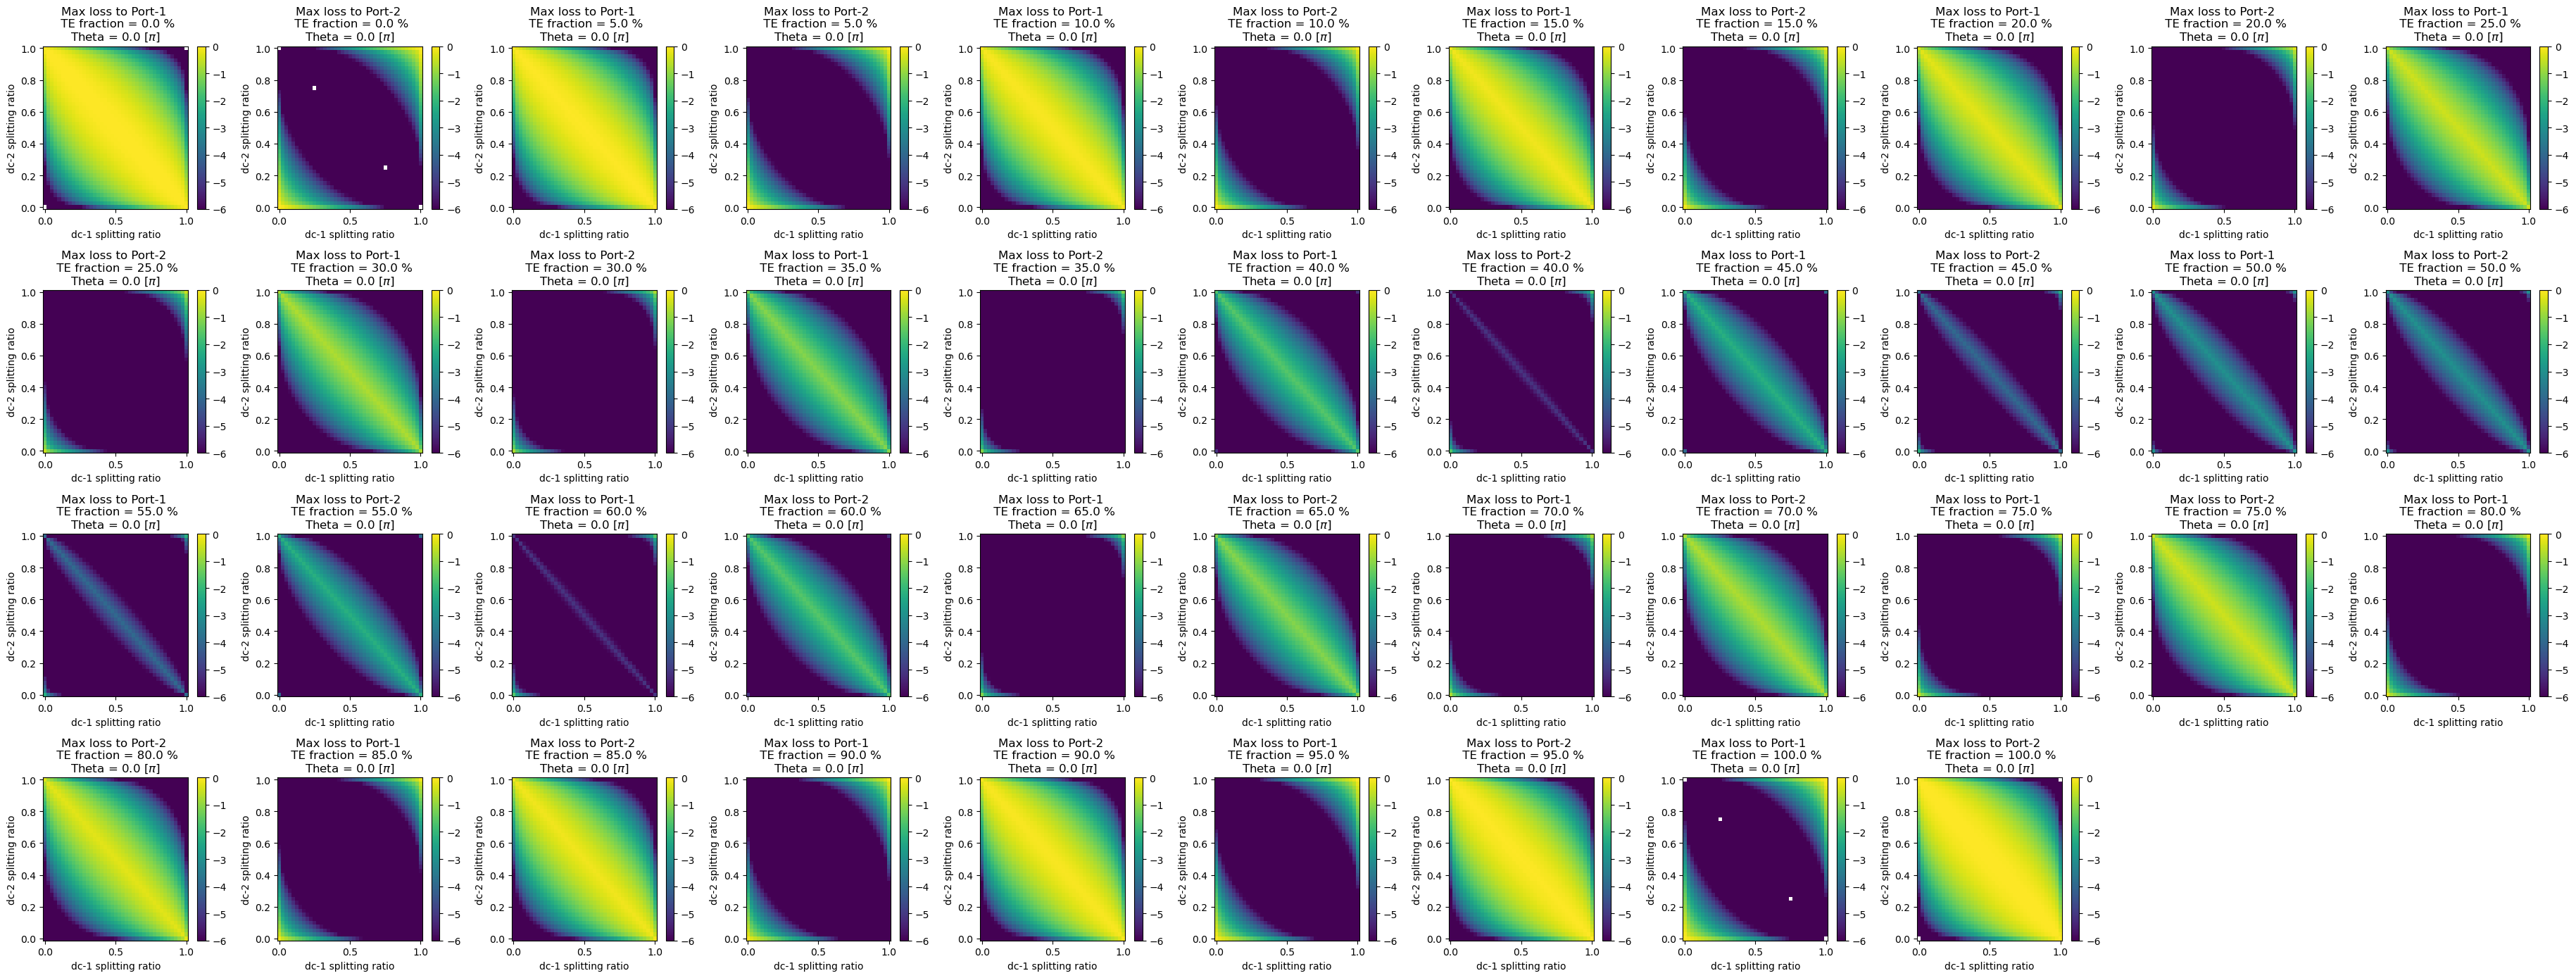

In [49]:
plt.figure(figsize=(3.5*len(pol_frac)/2,7*2))
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                arg_pol_frac = np.argmin(np.abs(pol_frac - pol_frac_val))
                idd_theta = 0
                # if pol_frac_val > 0.5:
                #                 idd_theta = -1
                # else: 
                #                 idd_theta = 0
                max_loss_port_1 = max_loss_single_stage_tunable_psrc[idd_theta, :,:,arg_pol_frac, 0, 0]
                max_loss_port_2 = max_loss_single_stage_tunable_psrc[idd_theta, :,:,arg_pol_frac, 1, 0]
                plt.subplot(4, int(len(pol_frac)/2)+1,2*idd_pol_frac + 1)
                X, Y = np.meshgrid(splitratio, splitratio)
                mesh = plt.pcolormesh(X, Y, max_loss_port_1)
                plt.xlabel("dc-1 splitting ratio")
                plt.ylabel("dc-2 splitting ratio")
                mesh.set_clim(-6,0)
                plt.colorbar()
                plt.title(f"Max loss to Port-1 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"Theta = {theta[idd_theta]/np.pi:0.1f}"+r" [$\pi$]")
                plt.subplot(4, int(len(pol_frac)/2)+1,2*idd_pol_frac + 2)
                X, Y = np.meshgrid(splitratio, splitratio)
                mesh = plt.pcolormesh(X, Y, max_loss_port_2)
                plt.xlabel("dc-1 splitting ratio")
                plt.ylabel("dc-2 splitting ratio")
                mesh.set_clim(-6,0)
                plt.colorbar()
                plt.title(f"Max loss to Port-2 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"Theta = {theta[idd_theta]/np.pi:0.1f}"+r" [$\pi$]")
plt.tight_layout()

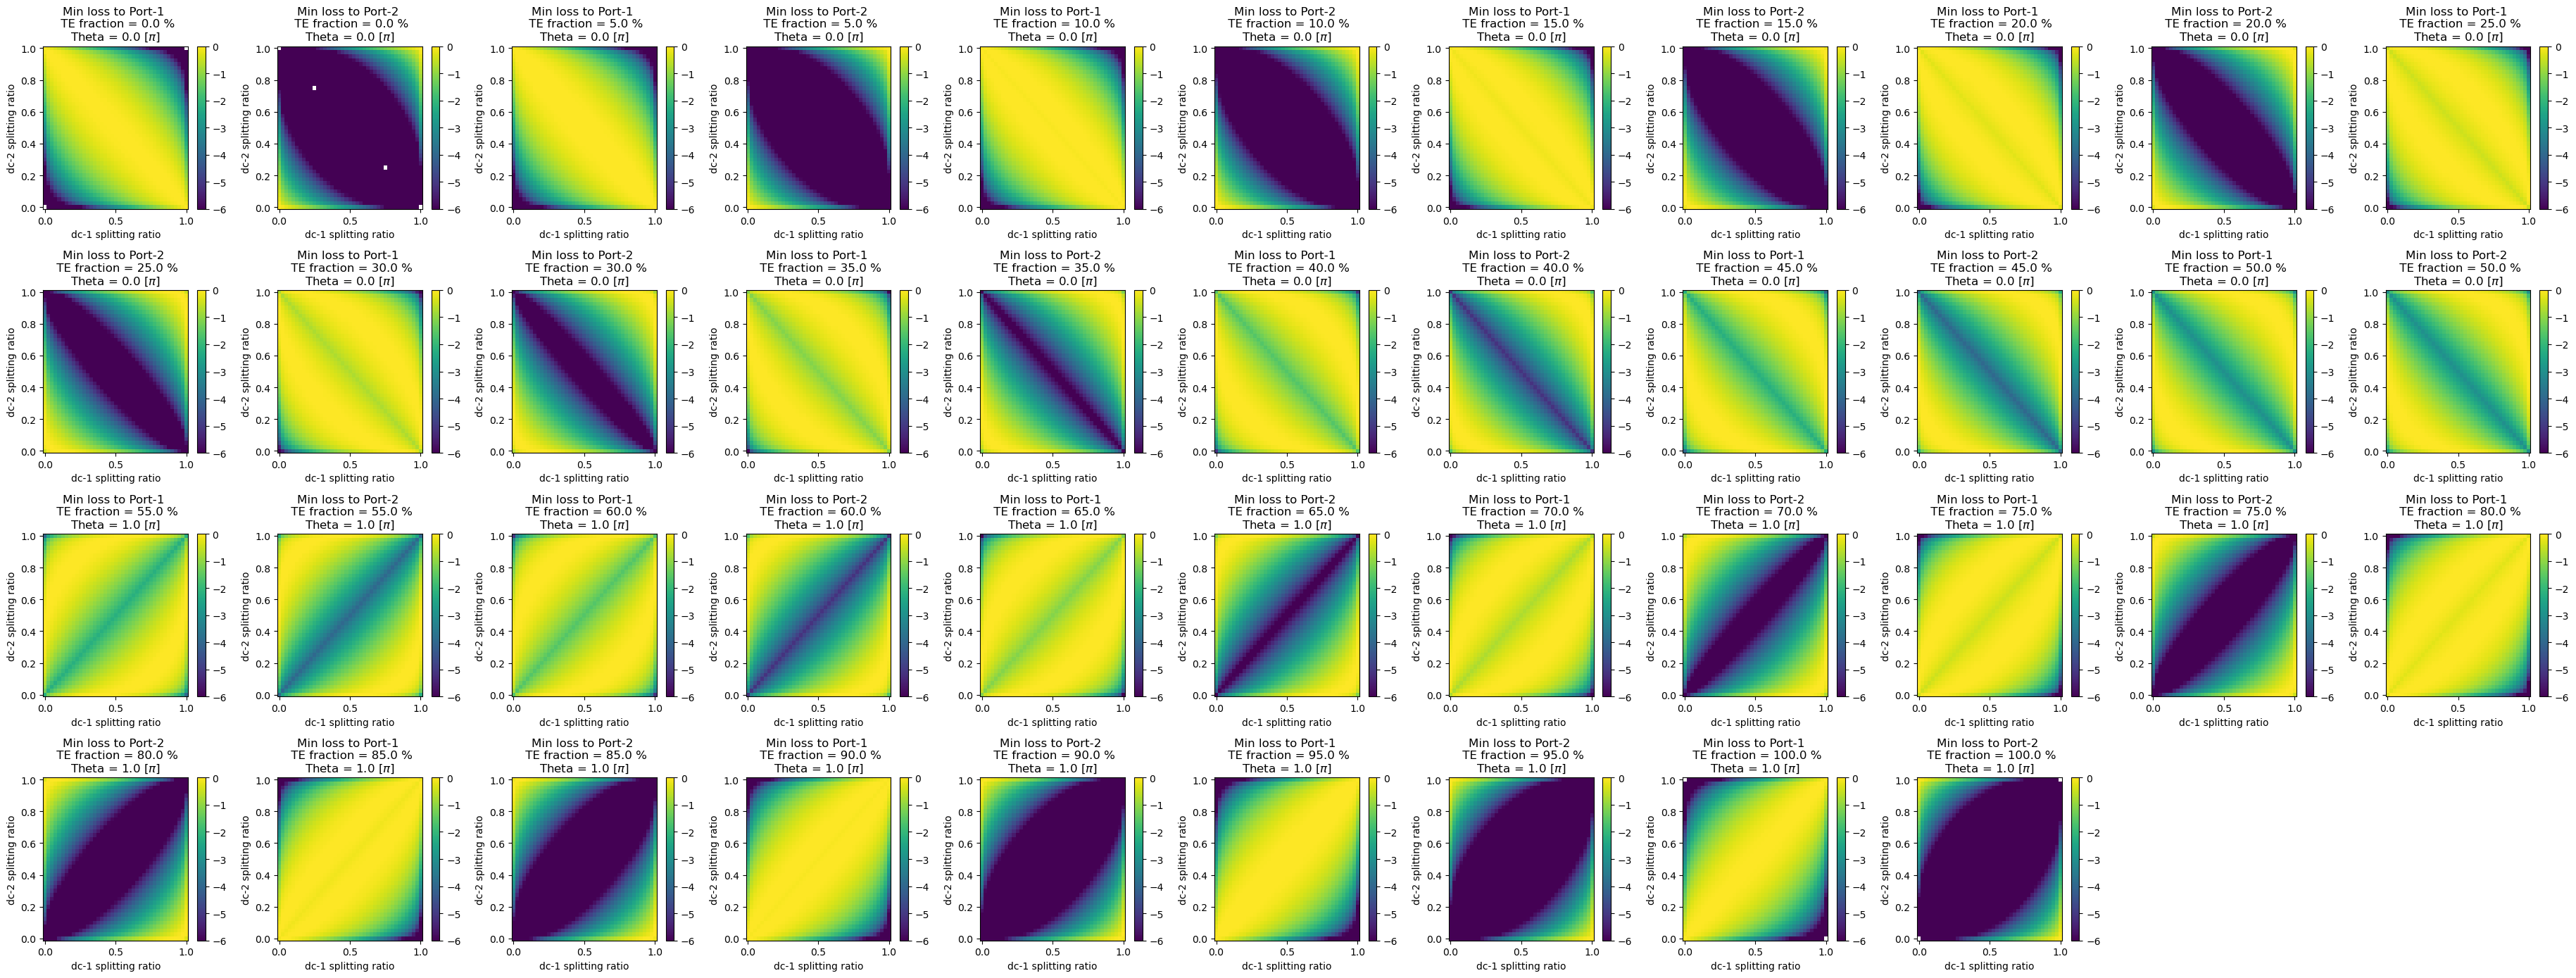

In [8]:
plt.figure(figsize=(3.5*len(pol_frac)/2,7*2))
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                arg_pol_frac = np.argmin(np.abs(pol_frac - pol_frac_val))
                if pol_frac_val > 0.5:
                                idd_theta = -1
                else: 
                                idd_theta = 0
                max_loss_port_1 = min_loss_single_stage_tunable_psrc[idd_theta, :,:,arg_pol_frac, 0, 0]
                max_loss_port_2 = min_loss_single_stage_tunable_psrc[idd_theta, :,:,arg_pol_frac, 1, 0]
                plt.subplot(4, int(len(pol_frac)/2)+1, 2*idd_pol_frac + 1)
                X, Y = np.meshgrid(splitratio, splitratio)
                mesh = plt.pcolormesh(X, Y, max_loss_port_1)
                plt.xlabel("dc-1 splitting ratio")
                plt.ylabel("dc-2 splitting ratio")
                mesh.set_clim(-6,0)
                plt.colorbar()
                plt.title(f"Min loss to Port-1 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"Theta = {theta[idd_theta]/np.pi:0.1f}"+r" [$\pi$]")
                plt.subplot(4, int(len(pol_frac)/2)+1,2*idd_pol_frac + 2)
                X, Y = np.meshgrid(splitratio, splitratio)
                mesh = plt.pcolormesh(X, Y, max_loss_port_2)
                plt.xlabel("dc-1 splitting ratio")
                plt.ylabel("dc-2 splitting ratio")
                mesh.set_clim(-6,0)
                plt.colorbar()
                plt.title(f"Min loss to Port-2 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"Theta = {theta[idd_theta]/np.pi:0.1f}"+r" [$\pi$]")
plt.tight_layout()

In [9]:
single_stage_tunable_psrc.shape

(401, 21, 41, 41, 21, 2, 1)

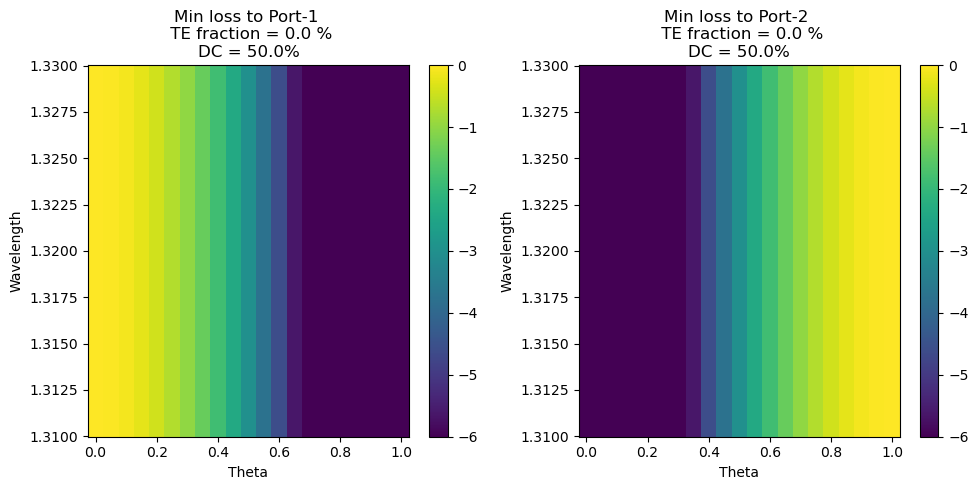

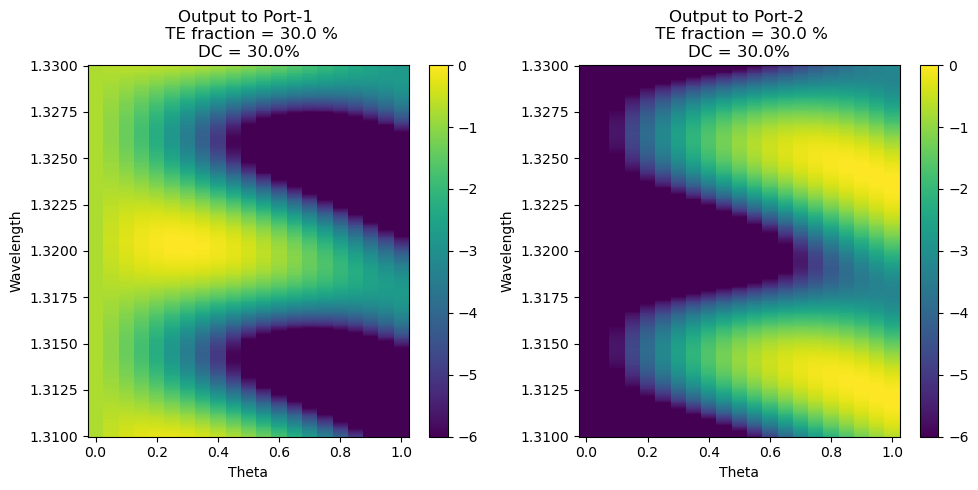

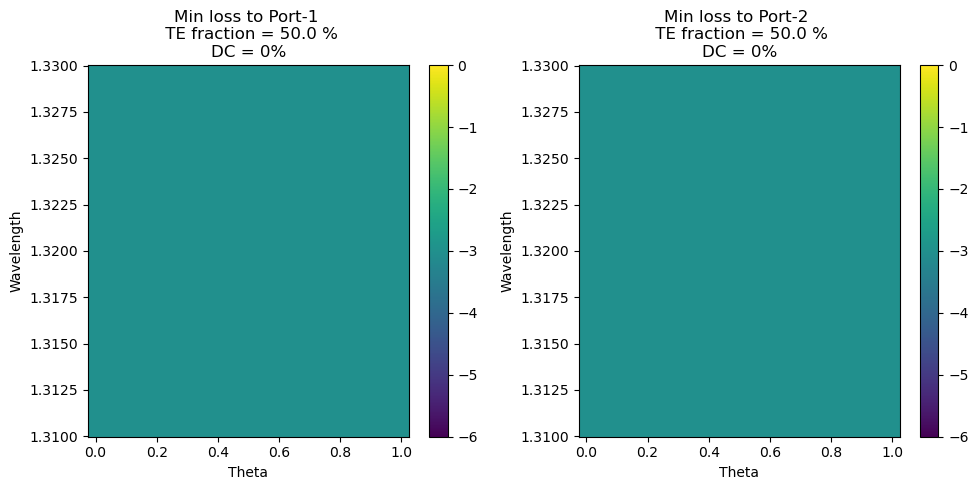

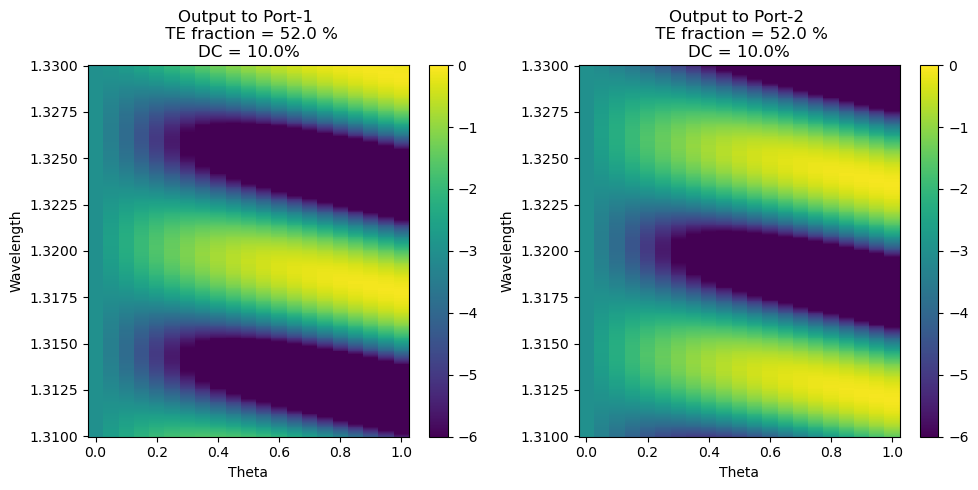

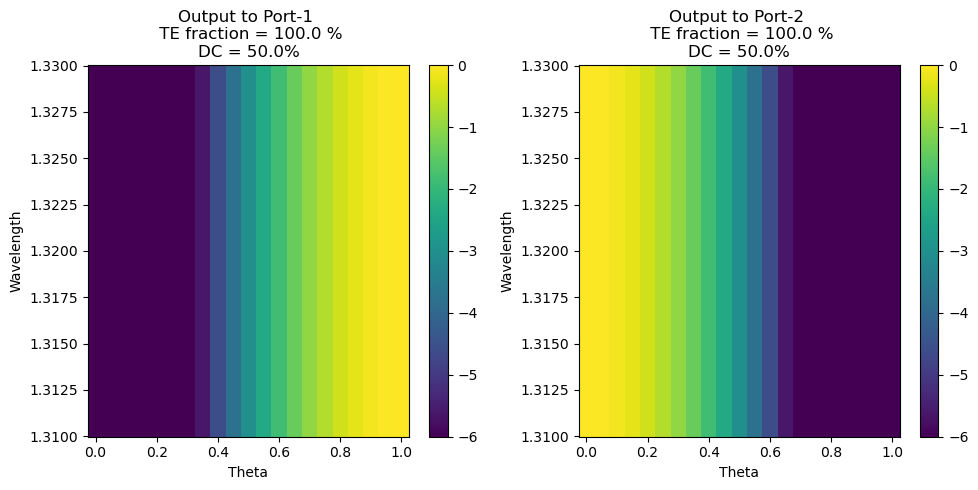

In [10]:
pol_frac_val = 0.0
plt.figure(figsize=(10,5))
arg_pol_frac = np.argmin(np.abs(pol_frac - pol_frac_val))
dc1_val = np.abs(0.5 - (1-pol_frac_val))
dc2_val = np.abs(0.5 - (1-pol_frac_val))
arg_dc1 = np.argmin(np.abs(splitratio-dc1_val))
arg_dc2 = np.argmin(np.abs(splitratio-dc2_val))
single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 0, 0]
plt.subplot(121)
X, Y = np.meshgrid(theta/np.pi, wavelength*1e6)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 0, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Min loss to Port-1 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {dc1_val*100}%")
plt.subplot(122)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 1, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Min loss to Port-2 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {dc1_val*100}%")
plt.tight_layout()
pol_frac_val = 1.0

pol_frac_val = 0.3
plt.figure(figsize=(10,5))
arg_pol_frac = np.argmin(np.abs(pol_frac - pol_frac_val))
dc1_val = np.abs(0.5 - (1-pol_frac_val))
dc2_val = np.abs(0.5 - (1-pol_frac_val))
dc1_val = 0.3
dc2_val = 0.7
arg_dc1 = np.argmin(np.abs(splitratio-dc1_val))
arg_dc2 = np.argmin(np.abs(splitratio-dc2_val))
plt.subplot(121)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 0, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Output to Port-1 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {dc1_val*100}%")
plt.subplot(122)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 1, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Output to Port-2 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {dc1_val*100}%")
plt.tight_layout()

pol_frac_val = 0.5
plt.figure(figsize=(10,5))
arg_pol_frac = np.argmin(np.abs(pol_frac - pol_frac_val))
dc1_val = np.abs(0.5 - (1-pol_frac_val))
dc2_val = np.abs(0.5 - (1-pol_frac_val))
dc1_val = 0
dc2_val = 1
arg_dc1 = np.argmin(np.abs(splitratio-dc1_val))
arg_dc2 = np.argmin(np.abs(splitratio-dc2_val))
single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 0, 0]
plt.subplot(121)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 0, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Min loss to Port-1 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {dc1_val*100}%")
plt.subplot(122)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 1, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Min loss to Port-2 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {dc1_val*100}%")
plt.tight_layout()

pol_frac_val = 0.52
plt.figure(figsize=(10,5))
arg_pol_frac = np.argmin(np.abs(pol_frac - pol_frac_val))

dc1_val = np.abs(0.5 - pol_frac_val)
dc2_val = np.abs(0.5 - pol_frac_val)
dc1_val = 0.1
dc2_val = 0.9
arg_dc1 = np.argmin(np.abs(splitratio-dc1_val))
arg_dc2 = np.argmin(np.abs(splitratio-dc2_val))
plt.subplot(121)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 0, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Output to Port-1 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {dc1_val*100}%")
plt.subplot(122)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 1, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Output to Port-2 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {dc1_val*100}%")
plt.tight_layout()

pol_frac_val = 1.0
plt.figure(figsize=(10,5))
arg_pol_frac = np.argmin(np.abs(pol_frac - pol_frac_val))
dc1_val = np.abs(0.5 - (1-pol_frac_val))
dc2_val = np.abs(0.5 - (1-pol_frac_val))
arg_dc1 = np.argmin(np.abs(splitratio-dc1_val))
arg_dc2 = np.argmin(np.abs(splitratio-dc2_val))
plt.subplot(121)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 0, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Output to Port-1 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {np.abs(0.5 - pol_frac_val)*100}%")
plt.subplot(122)
mesh = plt.pcolormesh(X, Y, 10*np.log10(np.abs(single_stage_tunable_psrc[:,:, arg_dc1,arg_dc2,arg_pol_frac, 1, 0])**2))
plt.xlabel("Theta")
plt.ylabel("Wavelength")
mesh.set_clim(-6,0)
plt.colorbar()
plt.title(f"Output to Port-2 \n TE fraction = {pol_frac_val*100:0.1f} %\n"+f"DC = {np.abs(0.5 - pol_frac_val)*100}%")
plt.tight_layout()

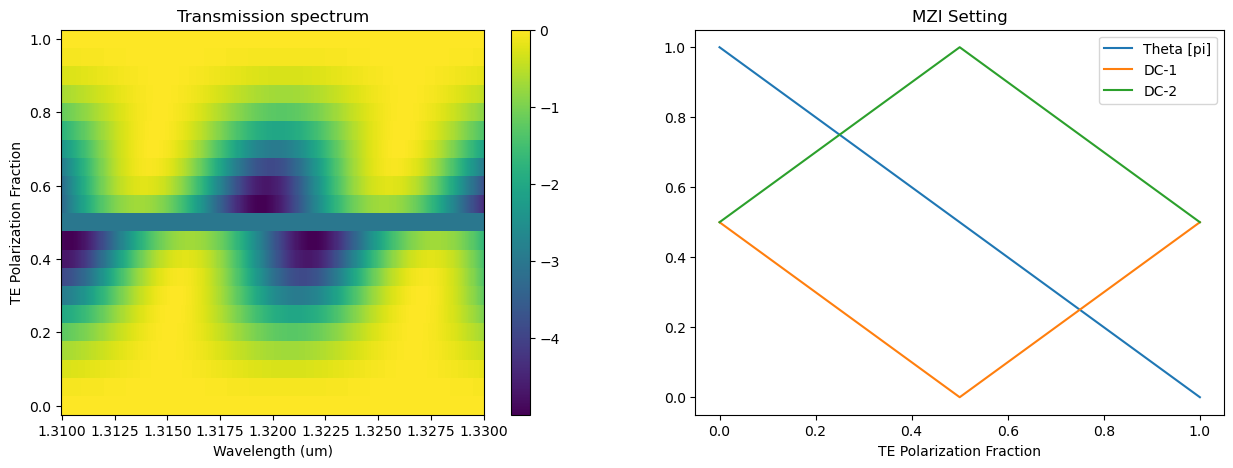

In [11]:
tf_port_2_combo  = np.array([])
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                dc1_val = np.abs(0.5 - (1-pol_frac_val))
                
                if pol_frac_val <= 0.5:
                                dc2_val = np.abs(0.5 - (1-pol_frac_val))
                if pol_frac_val >0.5:
                                dc2_val = 1.0 - (pol_frac_val - 0.5)
                theta_val = 1-pol_frac_val
                arg_min_dc1 = np.argmin(np.abs(splitratio-dc1_val))
                arg_min_dc2 = np.argmin(np.abs(splitratio-dc2_val))
                arg_theta = np.argmin(np.abs(theta-theta_val*np.pi))
                tf_port_2 = 10*np.log10(np.abs(single_stage_tunable_psrc[:, arg_theta, arg_min_dc1, arg_min_dc2, idd_pol_frac, 1, 0])**2).flatten()
                tf_port_2_combo = np.append(tf_port_2_combo, tf_port_2)
plt.figure(figsize=(15,5))
plt.subplot(121)
tf_port_2_combo.flatten()
tf_port_2_combo = tf_port_2_combo.reshape(len(pol_frac), len(wavelength))
X, Y = np.meshgrid(wavelength*1e6, pol_frac )
mesh = plt.pcolormesh(X, Y, tf_port_2_combo)
# mesh.set_clim(-6,0)
plt.colorbar()
plt.xlabel("Wavelength (um)")
plt.ylabel("TE Polarization Fraction")
plt.title("Transmission spectrum")
plt.subplot(122)
plt.plot(pol_frac, 1-pol_frac, label="Theta [pi]")
plt.plot(pol_frac, np.abs(0.5 - (1-pol_frac)), label="DC-1")
plt.plot(pol_frac, 1-np.abs(0.5 - (1-pol_frac)), label="DC-2")
plt.xlabel("TE Polarization Fraction")
plt.title("MZI Setting")
plt.legend()

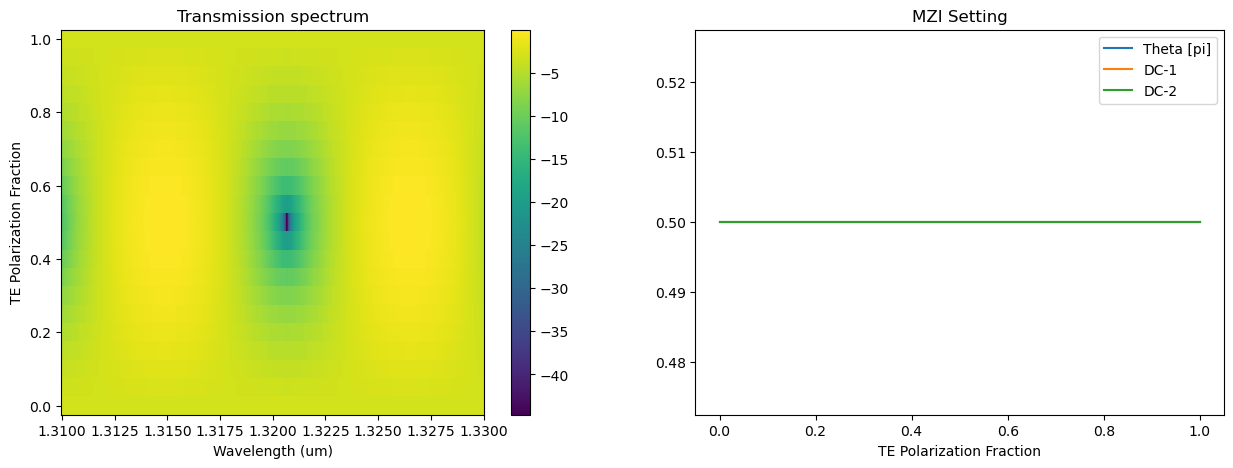

In [12]:
tf_port_2_combo  = np.array([])
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                dc1_val = 0.5
                dc2_val = 0.5
                theta_val = 0.5
                arg_min_dc1 = np.argmin(np.abs(splitratio-dc1_val))
                arg_min_dc2 = np.argmin(np.abs(splitratio-dc2_val))
                arg_theta = np.argmin(np.abs(theta-theta_val*np.pi))
                tf_port_2 = 10*np.log10(np.abs(single_stage_tunable_psrc[:, arg_theta, arg_min_dc1, arg_min_dc2, idd_pol_frac, 1, 0])**2).flatten()
                tf_port_2_combo = np.append(tf_port_2_combo, tf_port_2)
theta_list = []
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                if pol_frac_val >0.5:
                                theta_list += [0]
                else:
                                theta_list += [1]

theta_array = np.array(theta_list)

plt.figure(figsize=(15,5))
plt.subplot(121)
tf_port_2_combo.flatten()
tf_port_2_combo = tf_port_2_combo.reshape(len(pol_frac), len(wavelength))
X, Y = np.meshgrid(wavelength*1e6, pol_frac )
mesh = plt.pcolormesh(X, Y, tf_port_2_combo)
# mesh.set_clim(-6,0)
plt.colorbar()
plt.xlabel("Wavelength (um)")
plt.ylabel("TE Polarization Fraction")
plt.title("Transmission spectrum")
plt.subplot(122)
plt.plot(pol_frac, 0.5*np.ones(len(pol_frac)), label="Theta [pi]")
plt.plot(pol_frac, 0.5*np.ones(len(pol_frac)), label="DC-1")
plt.plot(pol_frac, 0.5*np.ones(len(pol_frac)), label="DC-2")
plt.xlabel("TE Polarization Fraction")
plt.title("MZI Setting")
plt.legend()

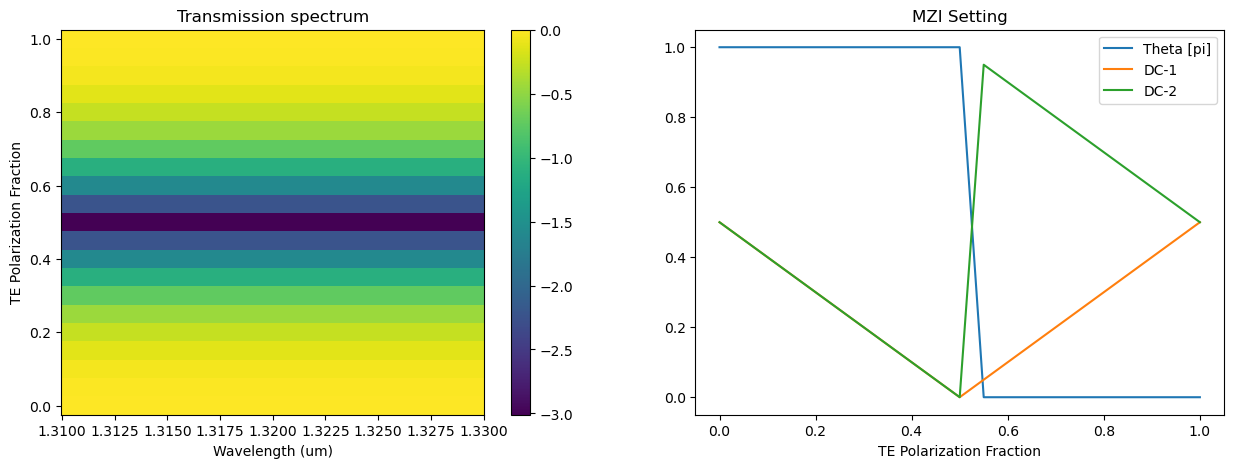

In [36]:
tf_port_2_combo  = np.array([])
dc1_val_list = []
dc2_val_list = []
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                dc1_val = np.abs(0.5 - (1-pol_frac_val))
                dc1_val_list += [dc1_val]
                if pol_frac_val <= 0.5:
                                dc2_val = np.abs(0.5 - (1-pol_frac_val))
                                dc2_val_list += [dc2_val]
                if pol_frac_val >0.5:
                                dc2_val = 1-(pol_frac_val - 0.5)
                                dc2_val_list += [dc2_val]
                if pol_frac_val < 0.5:
                                theta_val = 1
                else:
                                theta_val = 0
                arg_min_dc1 = np.argmin(np.abs(splitratio-dc1_val))
                arg_min_dc2 = np.argmin(np.abs(splitratio-dc2_val))
                arg_theta = np.argmin(np.abs(theta-theta_val*np.pi))
                tf_port_2 = 10*np.log10(np.abs(single_stage_tunable_psrc[:, arg_theta, arg_min_dc1, arg_min_dc2, idd_pol_frac, 1, 0])**2).flatten()
                tf_port_2_combo = np.append(tf_port_2_combo, tf_port_2)
theta_list = []
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                if pol_frac_val >0.5:
                                theta_list += [0]
                else:
                                theta_list += [1]

theta_array = np.array(theta_list)

plt.figure(figsize=(15,5))
plt.subplot(121)
tf_port_2_combo.flatten()
tf_port_2_combo = tf_port_2_combo.reshape(len(pol_frac), len(wavelength))
X, Y = np.meshgrid(wavelength*1e6, pol_frac )
mesh = plt.pcolormesh(X, Y, tf_port_2_combo)
# mesh.set_clim(-6,0)
plt.colorbar()
plt.xlabel("Wavelength (um)")
plt.ylabel("TE Polarization Fraction")
plt.title("Transmission spectrum")
plt.subplot(122)
plt.plot(pol_frac, theta_array, label="Theta [pi]")
plt.plot(pol_frac, dc1_val_list, label="DC-1")
plt.plot(pol_frac, dc2_val_list, label="DC-2")
plt.xlabel("TE Polarization Fraction")
plt.title("MZI Setting")
plt.legend()

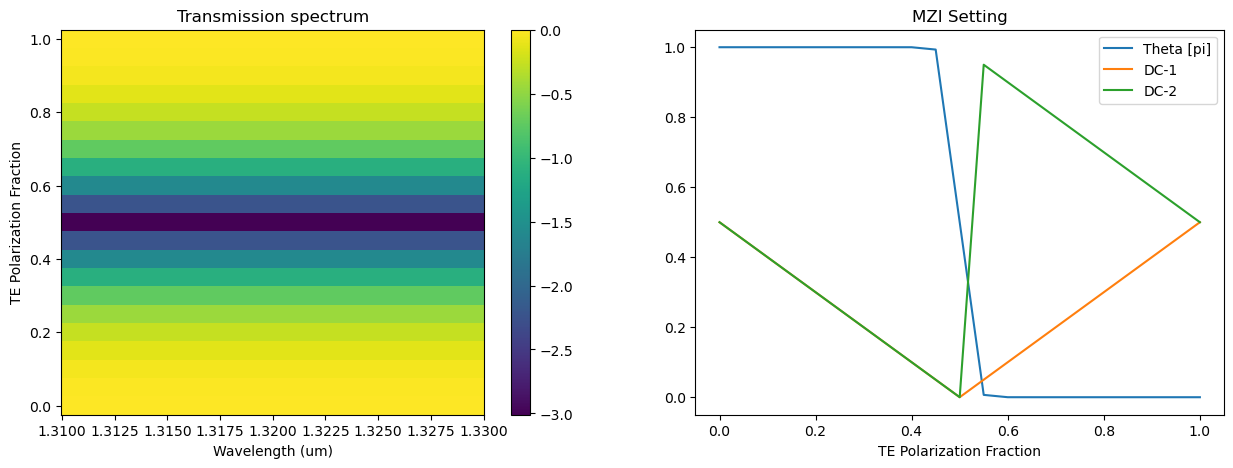

In [37]:
tf_port_2_combo  = np.array([])
dc1_val_list = []
dc2_val_list = []
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                dc1_val = np.abs(0.5 - (1-pol_frac_val))
                dc1_val_list += [dc1_val]
                if pol_frac_val <= 0.5:
                                dc2_val = np.abs(0.5 - (1-pol_frac_val))
                                dc2_val_list += [dc2_val]
                if pol_frac_val >0.5:
                                dc2_val = 1-(pol_frac_val - 0.5)
                                dc2_val_list += [dc2_val]
                def sig(x):
                                 return 1 - 1/(1 + np.exp(-(x-0.5)*100))
                theta_val = sig(pol_frac_val)
                # theta_val = np.pi
                arg_min_dc1 = np.argmin(np.abs(splitratio-dc1_val))
                arg_min_dc2 = np.argmin(np.abs(splitratio-dc2_val))
                arg_theta = np.argmin(np.abs(theta-theta_val*np.pi))
                tf_port_2 = 10*np.log10(np.abs(single_stage_tunable_psrc[:, arg_theta, arg_min_dc1, arg_min_dc2, idd_pol_frac, 1, 0])**2).flatten()
                tf_port_2_combo = np.append(tf_port_2_combo, tf_port_2)
theta_list = []
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                if pol_frac_val >0.5:
                                theta_list += [0]
                else:
                                theta_list += [1]

plt.figure(figsize=(15,5))
plt.subplot(121)
tf_port_2_combo.flatten()
tf_port_2_combo = tf_port_2_combo.reshape(len(pol_frac), len(wavelength))
X, Y = np.meshgrid(wavelength*1e6, pol_frac )
mesh = plt.pcolormesh(X, Y, tf_port_2_combo)
# mesh.set_clim(-6,0)
plt.colorbar()
plt.xlabel("Wavelength (um)")
plt.ylabel("TE Polarization Fraction")
plt.title("Transmission spectrum")
plt.subplot(122)
plt.plot(pol_frac, sig(pol_frac), label="Theta [pi]")
plt.plot(pol_frac, dc1_val_list, label="DC-1")
plt.plot(pol_frac, dc2_val_list, label="DC-2")
plt.xlabel("TE Polarization Fraction")
plt.title("MZI Setting")
plt.legend()

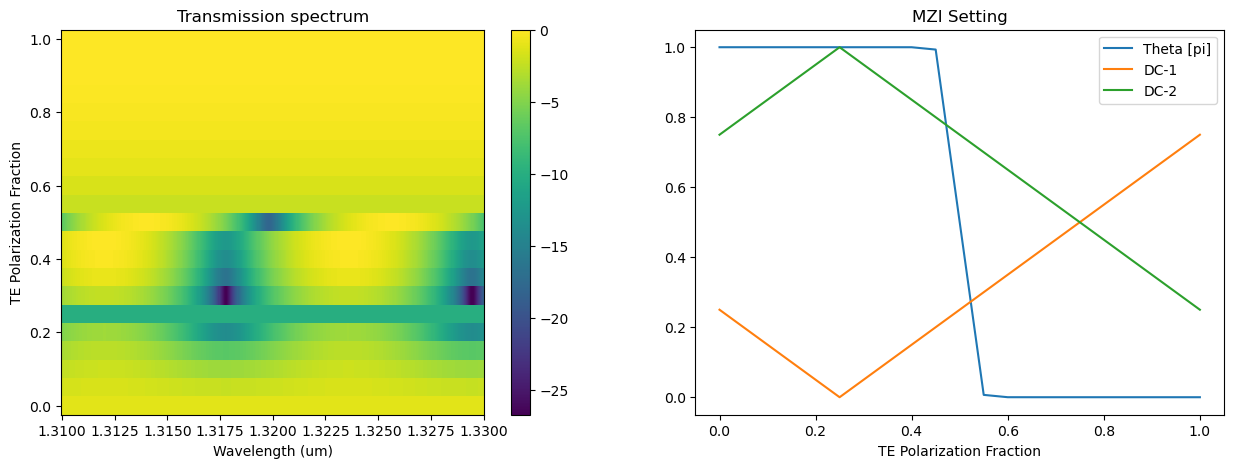

In [47]:
tf_port_2_combo  = np.array([])
dc1_val_list = []
dc2_val_list = []
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                dc1_val = np.abs(0.75 - (1-pol_frac_val))
                dc1_val_list += [dc1_val]
                
                dc2_val = 1-np.abs(0.75 - (1-pol_frac_val))
                dc2_val_list += [dc2_val]
                # if pol_frac_val <= 0.25:
                #                 dc2_val = 0.75 + pol_frac_val
                #                 dc2_val_list += [dc2_val]
                # if pol_frac_val >0.25:
                #                 dc2_val = 2 - pol_frac_val - 0.75
                #                 dc2_val_list += [dc2_val]
                def sig(x):
                                 return 1 - 1/(1 + np.exp(-(x-0.5)*100))
                theta_val = sig(pol_frac_val)
                # theta_val = np.pi
                arg_min_dc1 = np.argmin(np.abs(splitratio-dc1_val))
                arg_min_dc2 = np.argmin(np.abs(splitratio-dc2_val))
                arg_theta = np.argmin(np.abs(theta-theta_val*np.pi))
                tf_port_2 = 10*np.log10(np.abs(single_stage_tunable_psrc[:, arg_theta, arg_min_dc1, arg_min_dc2, idd_pol_frac, 1, 0])**2).flatten()
                tf_port_2_combo = np.append(tf_port_2_combo, tf_port_2)
theta_list = []
for idd_pol_frac, pol_frac_val in enumerate(pol_frac):
                if pol_frac_val >0.5:
                                theta_list += [0]
                else:
                                theta_list += [1]

plt.figure(figsize=(15,5))
plt.subplot(121)
tf_port_2_combo.flatten()
tf_port_2_combo = tf_port_2_combo.reshape(len(pol_frac), len(wavelength))
X, Y = np.meshgrid(wavelength*1e6, pol_frac )
mesh = plt.pcolormesh(X, Y, tf_port_2_combo)
# mesh.set_clim(-6,0)
plt.colorbar()
plt.xlabel("Wavelength (um)")
plt.ylabel("TE Polarization Fraction")
plt.title("Transmission spectrum")
plt.subplot(122)
plt.plot(pol_frac, sig(pol_frac), label="Theta [pi]")
plt.plot(pol_frac, dc1_val_list, label="DC-1")
plt.plot(pol_frac, dc2_val_list, label="DC-2")
plt.xlabel("TE Polarization Fraction")
plt.title("MZI Setting")
plt.legend()